In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
import math
import librosa
import scipy.signal
import os
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.signal
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import torchaudio.transforms as T
import torch.nn.functional as F
from scipy.signal import resample
from tqdm import tqdm
from geomloss import SamplesLoss
import os
import time
from tqdm import tqdm
import csv
import geomloss
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [34]:
!pip install torchinfo

In [3]:
def set_all_seeds(num):
    random.seed(num)
    np.random.seed(num)
    torch.manual_seed(num)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(num)

set_all_seeds(42)

## Configuración inicial para generar dataset sinteticos

In [4]:
base_path = "./features/time_domain_win_cut_pad/"
categories = ["chew", "elpp", "shiv"]
file_limit = 4266  
grouped_files = defaultdict(list)

if not os.path.exists(base_path):
    print(f"Error: Directory '{base_path}' not found.")
    exit()

print(f"Scanning directory: {base_path}\n")

for root, dirs, files in os.walk(base_path):
    folder_name = os.path.basename(root)
    
    if folder_name in categories:
        print(f"Processing folder: {folder_name}, Found {len(files)} files.")

        for file in files:
            if file.endswith(".pt") and len(grouped_files[folder_name]) < file_limit:
                file_path = os.path.join(root, file)
                grouped_files[folder_name].append(file_path)
                print(f"Added {file} to category '{folder_name}'")

Scanning directory: ./features/time_domain_win_cut_pad/

Processing folder: chew, Found 4266 files.
Added C3-CZ_0.0_21.0048.pt to category 'chew'
Added C3-CZ_0.2405_2.5624.pt to category 'chew'
Added C3-CZ_10.4038_12.6573.pt to category 'chew'
Added C3-CZ_100.0431_110.1627.pt to category 'chew'
Added C3-CZ_1002.0443_1005.8908.pt to category 'chew'
Added C3-CZ_1007.3117_1010.1994.pt to category 'chew'
Added C3-CZ_1026.2655_1029.0685.pt to category 'chew'
Added C3-CZ_105.0722_110.9278.pt to category 'chew'
Added C3-CZ_105.7222_115.6.pt to category 'chew'
Added C3-CZ_1067.0648_1079.0259.pt to category 'chew'
Added C3-CZ_1086.1008_1120.6059.pt to category 'chew'
Added C3-CZ_1130.2026_1142.4228.pt to category 'chew'
Added C3-CZ_114.0141_129.7887.pt to category 'chew'
Added C3-CZ_114.0481_119.7789.pt to category 'chew'
Added C3-CZ_115.0957_119.5215.pt to category 'chew'
Added C3-CZ_115.2294_179.9893.pt to category 'chew'
Added C3-CZ_1152.0601_1154.6503.pt to category 'chew'
Added C3-CZ_116.1

In [5]:
chew_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['chew']], axis=0)
elpp_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['elpp']], axis=0)
shiv_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['shiv']], axis=0)

In [6]:
print(chew_data.shape)
print(elpp_data.shape)
print(shiv_data.shape)

(4266, 512)
(156, 512)
(2762, 512)


In [7]:
EEG_PATH = 'data'
EOG_ALL_EPOCHS = 'EOG_all_epochs.npy'
EMG_ALL_EPOCHS = 'EMG_all_epochs.npy'
EEG_ALL_EPOCHS = 'EEG_all_epochs.npy'

In [8]:
def show_data_informations(signal, signal_type):
    print(f"Data type {signal_type}:", type(signal))
    print(f"Data shape {signal_type}:", signal.shape)

In [9]:
eog_data = np.load(os.path.join(EEG_PATH, EOG_ALL_EPOCHS))
emg_data = np.load(os.path.join(EEG_PATH, EMG_ALL_EPOCHS))
eeg_data = np.load(os.path.join(EEG_PATH, EEG_ALL_EPOCHS))

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Data type EOG: <class 'numpy.ndarray'>
Data shape EOG: (3400, 512)
Data type EMG: <class 'numpy.ndarray'>
Data shape EMG: (5598, 512)
Data type EEG: <class 'numpy.ndarray'>
Data shape EEG: (4514, 512)


In [10]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]
    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

In [11]:
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))

NOISE_all_random_chew = np.squeeze(random_signal(signal=chew_data, combine_num=1))
NOISE_all_random_elpp = np.squeeze(random_signal(signal=elpp_data, combine_num=1))
NOISE_all_random_shiv = np.squeeze(random_signal(signal=shiv_data, combine_num=1))
NOISE_all_random_eog = np.squeeze(random_signal(signal=eog_data, combine_num=1))
NOISE_all_random_emg = np.squeeze(random_signal(signal=emg_data, combine_num=1))

In [12]:
SNR_dB_chew = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_elpp = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_shiv = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_eog = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_emg = np.random.uniform(-7, 2, (eeg_data.shape[0]))

In [13]:
SNR_chew = 10 ** (0.1 * SNR_dB_chew)
SNR_elpp = 10 ** (0.1 * SNR_dB_elpp)
SNR_shiv = 10 ** (0.1 * SNR_dB_shiv)
SNR_eog = 10 ** (0.1 * SNR_dB_eog)
SNR_emg = 10 ** (0.1 * SNR_dB_emg)

In [14]:
num_eeg_samples = EEG_all_random.shape[0]
num_chew_samples = chew_data.shape[0]
num_elpp_samples = elpp_data.shape[0]
num_shiv_samples = shiv_data.shape[0]
num_eog_samples = eog_data.shape[0]
num_emg_samples = emg_data.shape[0]

In [15]:
needed_repetitions_chew = int(np.ceil(num_eeg_samples / num_chew_samples))
needed_repetitions_elpp = int(np.ceil(num_eeg_samples / num_elpp_samples))
needed_repetitions_shiv = int(np.ceil(num_eeg_samples / num_shiv_samples))
needed_repetitions_eog = int(np.ceil(num_eeg_samples / num_eog_samples))
needed_repetitions_emg = int(np.ceil(num_eeg_samples / num_emg_samples))

In [16]:
NOISE_all_random_chew = random_signal(signal=chew_data, combine_num=needed_repetitions_chew)
NOISE_all_random_elpp = random_signal(signal=elpp_data, combine_num=needed_repetitions_elpp)
NOISE_all_random_shiv = random_signal(signal=shiv_data, combine_num=needed_repetitions_shiv)
NOISE_all_random_eog = random_signal(signal=eog_data, combine_num=needed_repetitions_eog)
NOISE_all_random_emg = random_signal(signal=emg_data, combine_num=needed_repetitions_emg)

NOISE_all_random_chew = NOISE_all_random_chew.reshape(-1, chew_data.shape[1])
NOISE_all_random_elpp = NOISE_all_random_elpp.reshape(-1, elpp_data.shape[1])
NOISE_all_random_shiv = NOISE_all_random_shiv.reshape(-1, shiv_data.shape[1])
NOISE_all_random_eog = NOISE_all_random_eog.reshape(-1, eog_data.shape[1])
NOISE_all_random_emg = NOISE_all_random_emg.reshape(-1, emg_data.shape[1])

In [17]:
if NOISE_all_random_chew.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_chew.shape[0]
    extra_noise = random_signal(signal=chew_data, combine_num=1).reshape(-1, chew_data.shape[1])
    NOISE_all_random_chew = np.concatenate((NOISE_all_random_chew, extra_noise), axis=0)

if NOISE_all_random_elpp.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_elpp.shape[0]
    extra_noise = random_signal(signal=elpp_data, combine_num=1).reshape(-1, elpp_data.shape[1])
    NOISE_all_random_elpp = np.concatenate((NOISE_all_random_elpp, extra_noise), axis=0)
    
if NOISE_all_random_shiv.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_shiv.shape[0]
    extra_noise = random_signal(signal=shiv_data, combine_num=1).reshape(-1, shiv_data.shape[1])
    NOISE_all_random_shiv = np.concatenate((NOISE_all_random_shiv, extra_noise), axis=0)

if NOISE_all_random_eog.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_eog.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1).reshape(-1, eog_data.shape[1])
    NOISE_all_random_eog = np.concatenate((NOISE_all_random_eog, extra_noise), axis=0)

if NOISE_all_random_emg.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_emg.shape[0]
    extra_noise = random_signal(signal=emg_data, combine_num=1).reshape(-1, emg_data.shape[1])
    NOISE_all_random_emg = np.concatenate((NOISE_all_random_emg, extra_noise), axis=0)

In [18]:
NOISE_all_random_chew = NOISE_all_random_chew[:num_eeg_samples]
NOISE_all_random_elpp = NOISE_all_random_elpp[:num_eeg_samples]
NOISE_all_random_shiv = NOISE_all_random_shiv[:num_eeg_samples]
NOISE_all_random_eog = NOISE_all_random_eog[:num_eeg_samples]
NOISE_all_random_emg = NOISE_all_random_emg[:num_eeg_samples]

In [19]:
noiseEEG_CHEW = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_chew = NOISE_all_random_chew[i]
    coe_chew = get_rms(eeg) / (get_rms(noise_chew) * SNR_chew[i])
    noise_chew = noise_chew * coe_chew
    noise_eeg_chew = eeg + noise_chew
    noiseEEG_CHEW.append(noise_eeg_chew)

noiseEEG_ELPP = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_elpp = NOISE_all_random_elpp[i]
    coe_elpp = get_rms(eeg) / (get_rms(noise_elpp) * SNR_elpp[i])
    noise_elpp = noise_elpp * coe_elpp
    noise_eeg_elpp = eeg + noise_elpp
    noiseEEG_ELPP.append(noise_eeg_elpp)

noiseEEG_SHIV = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_shiv = NOISE_all_random_shiv[i]
    coe_shiv = get_rms(eeg) / (get_rms(noise_shiv) * SNR_shiv[i])
    noise_shiv = noise_shiv * coe_shiv
    noise_eeg_shiv = eeg + noise_shiv
    noiseEEG_SHIV.append(noise_eeg_shiv)

noiseEEG_EOG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_eog = NOISE_all_random_eog[i]
    coe_eog = get_rms(eeg) / (get_rms(noise_eog) * SNR_eog[i])
    noise_eog = noise_eog * coe_eog
    noise_eeg_eog = eeg + noise_eog
    noiseEEG_EOG.append(noise_eeg_eog)

noiseEEG_EMG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_emg = NOISE_all_random_emg[i]
    coe_emg = get_rms(eeg) / (get_rms(noise_emg) * SNR_emg[i])
    noise_emg = noise_emg * coe_emg
    noise_eeg_emg = eeg + noise_emg
    noiseEEG_EMG.append(noise_eeg_emg)

In [20]:
noiseEEG_CHEW = np.array(noiseEEG_CHEW)
noiseEEG_ELPP = np.array(noiseEEG_ELPP)
noiseEEG_SHIV = np.array(noiseEEG_SHIV)
noiseEEG_EOG = np.array(noiseEEG_EOG)
noiseEEG_EMG = np.array(noiseEEG_EMG)

In [21]:
EEG_end_standard = EEG_all_random / np.std(EEG_all_random)
noiseEEG_CHEW_standard = noiseEEG_CHEW / np.std(noiseEEG_CHEW)
noiseEEG_ELPP_standard = noiseEEG_ELPP / np.std(noiseEEG_ELPP)
noiseEEG_SHIV_standard = noiseEEG_SHIV / np.std(noiseEEG_SHIV)
noiseEEG_EOG_standard = noiseEEG_EOG / np.std(noiseEEG_EOG)
noiseEEG_EMG_standard = noiseEEG_EMG / np.std(noiseEEG_EMG)

In [22]:
EEG = EEG_end_standard.flatten()
EEG_CHEW = noiseEEG_CHEW_standard.flatten()
EEG_ELPP = noiseEEG_ELPP_standard.flatten()
EEG_SHIV = noiseEEG_SHIV_standard.flatten()
EEG_EOG = noiseEEG_EOG_standard.flatten()
EEG_EMG = noiseEEG_EMG_standard.flatten()

In [23]:
print(f'EEG: {EEG.shape}')
print(f'EEG_CHEW: {EEG_CHEW.shape}')
print(f'EEG_ELPP: {EEG_ELPP.shape}')
print(f'EEG_SHIV: {EEG_SHIV.shape}')
print(f'EEG_EOG: {EEG_EOG.shape}')
print(f'EEG_EMG: {EEG_EMG.shape}')

EEG: (2311168,)
EEG_CHEW: (2311168,)
EEG_ELPP: (2311168,)
EEG_SHIV: (2311168,)
EEG_EOG: (2311168,)
EEG_EMG: (2311168,)


## Generar dataset real

In [24]:
features_path = './features/time_domain_win_cut_pad/'
files_by_subfolder = {}

for root, dirs, files in os.walk(features_path):
    relative_path = os.path.relpath(root, features_path)
    if relative_path == '.':
        continue
    if relative_path not in files_by_subfolder:
        files_by_subfolder[relative_path] = []
    for file in files:
        full_path = os.path.join(root, file)
        files_by_subfolder[relative_path].append(full_path)

value_map = {'base':0, 'chew':1,  'elpp':2, 'eyem': 3, 'musc': 4, 'shiv':5}
selected_pt_files = []
selected_labels = []

for subfolder, files in files_by_subfolder.items():
    if subfolder in value_map:
        class_label = value_map[subfolder]
    
        sampled_files = random.sample(files, min(len(files), 4514))
        
        selected_pt_files.extend(sampled_files)
        selected_labels.extend([class_label] * len(sampled_files))

for class_name, class_id in value_map.items():
    count = sum(1 for lbl in selected_labels if lbl == class_id)
    print(f"Class {class_name} (ID {class_id}): {count} samples")

Class base (ID 0): 4514 samples
Class chew (ID 1): 4266 samples
Class elpp (ID 2): 156 samples
Class eyem (ID 3): 4514 samples
Class musc (ID 4): 4514 samples
Class shiv (ID 5): 2762 samples


In [25]:
class CustomDatasetTarget(Dataset):
    def __init__(self, files, labelss, normalization_type='min_max'):
        self.files = files
        self.labels = labelss
        self.normalization_type = normalization_type

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        data = torch.load(file_path, weights_only=False)

        if isinstance(data, np.ndarray):
            data = data.astype(np.float32)
        elif isinstance(data, torch.Tensor):
            data = data.to(torch.float32).unsqueeze(-1)
        else:
            raise ValueError(f"Unsupported data type for file: {file_path}")

        if self.normalization_type == 'min_max':
            data = self.min_max_normalize(data)
        elif self.normalization_type == 'standardize':
            data = self.standardize(data)
        else:
            raise ValueError(f"Unsupported normalization type: {self.normalization_type}")

        return data, label

    def min_max_normalize(self, data):
        min_val = data.min()
        max_val = data.max()
        return (data - min_val) / (max_val - min_val)

    def standardize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

In [26]:
dataset_source = CustomDatasetTarget(selected_pt_files, selected_labels, normalization_type='standardize')

In [27]:
class CustomEEGDataset(Dataset):
    def __init__(self, eeg, eeg_chew,  eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, window_size=512):
        self.signals = self.signals = [
            (self.normalize(eeg), 0),
            (self.normalize(eeg_chew), 1),
            (self.normalize(eeg_elpp), 2),
            (self.normalize(eeg_eog), 3),
            (self.normalize(eeg_emg), 4),
            (self.normalize(eeg_shiv), 5)
        ]
        self.window_size = window_size
        self.samples = []
        
        for signal, label in self.signals:
            num_samples = len(signal) // window_size
            for i in range(num_samples):
                start = i * window_size
                end = start + window_size
                self.samples.append((torch.tensor(signal[start:end], dtype=torch.float32), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample, label = self.samples[idx]
        return sample, torch.tensor(label, dtype=torch.long)
    
    @staticmethod
    def normalize(data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

def get_dataloaders(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, batch_size=32, shuffle=True):
    dataset = CustomEEGDataset(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv)
    
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5:0}
    for _, label in dataset.samples:
        class_counts[label] += 1
    
    print("\n=== Sample Counts Per Class ===")
    print(f"EEG (0)  : {class_counts[0]}")
    print(f"Chew (1)  : {class_counts[1]}")
    print(f"Elpp (2)  : {class_counts[2]}")
    print(f"EOG  (3)  : {class_counts[3]}")
    print(f"EMG  (4)  : {class_counts[4]}")
    print(f"Shiv (5)  : {class_counts[5]}\n")
    return dataset

In [28]:
dataset_target = get_dataloaders(
    EEG, 
    EEG_CHEW[0:4266*512+1],
    EEG_ELPP[0:156*512+1], 
    EEG_EOG, 
    EEG_EMG, 
    EEG_SHIV[0:2347*512+1], 
    batch_size=32, shuffle=False)


=== Sample Counts Per Class ===
EEG (0)  : 4514
Chew (1)  : 4266
Elpp (2)  : 156
EOG  (3)  : 4514
EMG  (4)  : 4514
Shiv (5)  : 2347



## Alinear para entrenamiento source y taget

In [29]:
class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
    
    def __len__(self):
        return self.min_length
    
    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]
        
        return x_feat_source, y_label_source, x_feat_target, y_label_target

In [30]:
import random
import torch
from torch.utils.data import DataLoader, random_split, Dataset

class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target, n_fft=128, hop_length=64, norm_type="zscore", 
                 apply_specaug_source=False, time_masking_ratio=0.1, freq_masking_ratio=0.1):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.norm_type = norm_type
        self.apply_specaug_source = apply_specaug_source
        self.time_masking_ratio = time_masking_ratio
        self.freq_masking_ratio = freq_masking_ratio

    def __len__(self):
        return self.min_length
    
    def apply_stft(self, eeg_signal):
        return torch.stft(eeg_signal, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True).abs()

    def normalize_minmax(self, tensor):
        min_val = tensor.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_val = tensor.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        return (tensor - min_val) / (max_val - min_val + 1e-8)

    def normalize_zscore(self, tensor):
        mean = tensor.mean(dim=(-1, -2), keepdim=True)
        std = tensor.std(dim=(-1, -2), keepdim=True) + 1e-8
        return (tensor - mean) / std

    def normalize(self, tensor):
        if self.norm_type == "minmax":
            return self.normalize_minmax(tensor)
        elif self.norm_type == "zscore":
            return self.normalize_zscore(tensor)
        else:
            return tensor

    def spec_augment(self, spectrogram):
        # Apply Frequency Masking
        num_freq_bins = spectrogram.shape[-2]
        num_time_bins = spectrogram.shape[-1]

        # Frequency Masking
        num_freq_mask = int(self.freq_masking_ratio * num_freq_bins)
        if num_freq_mask > 0:
            f_start = random.randint(0, num_freq_bins - num_freq_mask)
            spectrogram[f_start:f_start + num_freq_mask, :] = 0.0

        # Time Masking
        num_time_mask = int(self.time_masking_ratio * num_time_bins)
        if num_time_mask > 0:
            t_start = random.randint(0, num_time_bins - num_time_mask)
            spectrogram[:, t_start:t_start + num_time_mask] = 0.0

        return spectrogram

    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]

        x_feat_source = torch.tensor(x_feat_source, dtype=torch.float32)
        x_feat_target = torch.tensor(x_feat_target, dtype=torch.float32)

        x_feat_source_stft = self.apply_stft(x_feat_source)
        x_feat_target_stft = self.apply_stft(x_feat_target)

        x_feat_source_stft = self.normalize(x_feat_source_stft)
        x_feat_target_stft = self.normalize(x_feat_target_stft)

        if self.apply_specaug_source:
            x_feat_source_stft = self.spec_augment(x_feat_source_stft)

        return x_feat_source_stft.unsqueeze(0), y_label_source, x_feat_target_stft.unsqueeze(0), y_label_target


def get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, shuffle=True, norm_type="zscore",
                            apply_specaug_source=False):
    aligned_dataset = AlignedEEGDataset(
        dataset_source, dataset_target, norm_type=norm_type,
        apply_specaug_source=apply_specaug_source
    )
    
    train_size = int(0.8 * len(aligned_dataset))
    test_size = len(aligned_dataset) - train_size
    train_dataset, test_dataset = random_split(aligned_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32)


In [31]:
for x_feat_source, y_label_source, x_feat_target, y_label_target in train_loader:
    print(f"Source Features (Normalized STFT): {x_feat_source.shape}, Labels: {y_label_source}")
    print(f"Target Features (Normalized STFT): {x_feat_target.shape}, Labels: {y_label_target}")
    break

Source Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])
Target Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])


## Arquitectura de red neuronal

In [32]:
import torch
import torch.nn as nn

class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        return self.relu(out)

class ResNet2D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet2D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)

        features = x                  # features
        logits = self.fc(x)            # num_classes
        
        return logits, features

In [37]:
net = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6)
from torchinfo import summary

summary(net, input_size=(32, 1, 65, 9))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet2D                                 [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 33, 5]           --
│    └─Conv2d: 2-1                       [32, 64, 33, 5]           3,200
│    └─BatchNorm2d: 2-2                  [32, 64, 33, 5]           128
│    └─ReLU: 2-3                         [32, 64, 33, 5]           --
├─MaxPool2d: 1-2                         [32, 64, 17, 3]           --
├─Sequential: 1-3                        [32, 64, 17, 3]           --
│    └─ResidualBlock2D: 2-4              [32, 64, 17, 3]           --
│    │    └─Sequential: 3-1              [32, 64, 17, 3]           37,056
│    │    └─Sequential: 3-2              [32, 64, 17, 3]           37,056
│    │    └─ReLU: 3-3                    [32, 64, 17, 3]           --
│    └─ResidualBlock2D: 2-5              [32, 64, 17, 3]           --
│    │    └─Sequential: 3-4              [32, 64, 17, 3]           37,056

## Funcion de perdida de adaptación de dominio

In [33]:
def dynamic_sinkhorn_loss(
    x,
    y,
    blur,
):
    loss = geomloss.SamplesLoss("sinkhorn", blur=blur, scaling=0.9, reach=None)
    return loss(x, y)

def kl_divergence(p, q): 
    epsilon = 1e-6
    p = torch.clamp(p, min=epsilon)
    q = torch.clamp(q, min=epsilon)
    return torch.sum(p * torch.log(p / q), dim=-1)

def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    jsd = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    return jsd

def jensen_shannon_distance(p, q):
    jsd = jensen_shannon_divergence(p, q)
    jsd = torch.clamp(jsd, min=0.0)
    return torch.sqrt(jsd)

## Parametros iniciales de red neuronal

## Entrenamiento

In [37]:
import os
import csv
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from geomloss import SamplesLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-10)

num_epochs = 100
max_lambda_da = 1.0
warmup_epochs = 20
clip_value = 1.0

best_source_acc = 0.0
best_target_acc = 0.0
best_source_model_path = "best_model_source_stft_da.pt"
best_target_model_path = "best_model_target_stft_da.pt"

metrics_file = "training_metrics_stft.csv"
divergence_file = "divergence_metrics_stft.csv"

if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train CE Source Loss", "Train CE Target Loss",
                         "Train Source Acc", "Train Target Acc", 
                         "Val CE Source Loss", "Val CE Target Loss", 
                         "Val Source Acc", "Val Target Acc", 
                         "Train Time (sec)", "Val Time (sec)", "Epoch Time (sec)"])

if not os.path.exists(divergence_file):
    with open(divergence_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Avg KL Divergence", "Avg Jensen-Shannon Divergence", "Avg Jensen-Shannon Distance"])

max_distances = []
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    net.train()
    running_loss = 0.0
    running_ce_loss_source = 0.0
    running_ce_loss_target = 0.0
    train_correct_source, train_total_source = 0, 0
    train_correct_target, train_total_target = 0, 0

    current_lambda_da = max_lambda_da * min(1.0, epoch / warmup_epochs)

    train_start_time = time.time()
    
    total_kl_div = 0.0
    total_js_div = 0.0
    total_js_dist = 0.0
    divergence_count = 0

    for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
            train_loader, desc=f"Epoch {epoch} [Train]"):

        x_feat_source = x_feat_source.to(device)
        y_label_source = y_label_source.to(device)
        x_feat_target = x_feat_target.to(device)
        y_label_target = y_label_target.to(device)

        optimizer.zero_grad()

        logits_s, feat_s = net(x_feat_source)
        logits_t, feat_t = net(x_feat_target)

        kl_div = kl_divergence(feat_s, feat_t).mean().item()
        js_div = jensen_shannon_divergence(feat_s, feat_t).mean().item()
        js_dist = jensen_shannon_distance(feat_s, feat_t).mean().item()

        total_kl_div += kl_div
        total_js_div += js_div
        total_js_dist += js_dist
        divergence_count += 1

        cls_loss = F.cross_entropy(logits_s, y_label_source)

        pairwise_distances = torch.cdist(feat_s, feat_t, p=2)
        flattened_distances = pairwise_distances.view(-1)
        max_distance = torch.max(flattened_distances)
        max_distances.append(max_distance.detach().cpu().numpy())
        dynamic_blur_val = 0.05 * max_distance.detach().cpu().numpy()
        
        da_loss = dynamic_sinkhorn_loss(feat_s, feat_t, dynamic_blur_val)
        total_loss = cls_loss + current_lambda_da * da_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
        optimizer.step()

        running_loss += total_loss.item() * x_feat_source.size(0)
        running_ce_loss_source += cls_loss.item() * x_feat_source.size(0)

        preds_s = logits_s.argmax(dim=1)
        train_correct_source += (preds_s == y_label_source).sum().item()
        train_total_source += y_label_source.size(0)

        ce_loss_target = F.cross_entropy(logits_t, y_label_target)
        running_ce_loss_target += ce_loss_target.item() * x_feat_target.size(0)

        preds_t = logits_t.argmax(dim=1)
        train_correct_target += (preds_t == y_label_target).sum().item()
        train_total_target += y_label_target.size(0)

    train_time = time.time() - train_start_time
    avg_loss = running_loss / len(train_loader.dataset)
    avg_ce_loss_source = running_ce_loss_source / len(train_loader.dataset)
    avg_ce_loss_target = running_ce_loss_target / len(train_loader.dataset)
    train_acc_source = train_correct_source / train_total_source
    train_acc_target = train_correct_target / train_total_target

    avg_kl_div = total_kl_div / divergence_count
    avg_js_div = total_js_div / divergence_count
    avg_js_dist = total_js_dist / divergence_count

    with open(divergence_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_kl_div, avg_js_div, avg_js_dist])

    net.eval()
    correct_source, total_source = 0, 0
    correct_target, total_target = 0, 0
    running_ce_loss_val_source = 0.0
    running_ce_loss_val_target = 0.0

    val_start_time = time.time()
    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
                test_loader, desc=f"Epoch {epoch} [Test]"):

            x_feat_source = x_feat_source.to(device)
            y_label_source = y_label_source.to(device)
            x_feat_target = x_feat_target.to(device)
            y_label_target = y_label_target.to(device)

            logits_s, _ = net(x_feat_source)
            logits_t, _ = net(x_feat_target)

            predictions_s = logits_s.argmax(dim=1)
            correct_source += (predictions_s == y_label_source).sum().item()
            total_source += y_label_source.size(0)

            predictions_t = logits_t.argmax(dim=1)
            correct_target += (predictions_t == y_label_target).sum().item()
            total_target += y_label_target.size(0)

            ce_loss_val_source = F.cross_entropy(logits_s, y_label_source)
            ce_loss_val_target = F.cross_entropy(logits_t, y_label_target)
            running_ce_loss_val_source += ce_loss_val_source.item() * x_feat_source.size(0)
            running_ce_loss_val_target += ce_loss_val_target.item() * x_feat_target.size(0)

    val_time = time.time() - val_start_time
    accuracy_source = correct_source / total_source
    accuracy_target = correct_target / total_target

    avg_ce_loss_val_source = running_ce_loss_val_source / len(test_loader.dataset)
    avg_ce_loss_val_target = running_ce_loss_val_target / len(test_loader.dataset)
    epoch_time = time.time() - epoch_start_time

    #print(f"Epoch {epoch}/{num_epochs} - "
    #      f"Train Loss: {avg_loss:.4f}, Train CE Source Loss: {avg_ce_loss_source:.4f}, Train CE Target Loss: {avg_ce_loss_target:.4f}, "
    #      f"Train Source Acc: {train_acc_source:.4f}, Train Target Acc: {train_acc_target:.4f}, "
    #      f"Val CE Source Loss: {avg_ce_loss_val_source:.4f}, Val CE Target Loss: {avg_ce_loss_val_target:.4f}, "
    #      f"Val Source Acc: {accuracy_source:.4f}, Val Target Acc: {accuracy_target:.4f}, "
    #      f"Train Time: {train_time:.2f} sec, Val Time: {val_time:.2f} sec, Epoch Time: {epoch_time:.2f} sec")

    print(f"Epoch {epoch}/{num_epochs}\n"
          #f"Train CE Source Loss: \t {avg_ce_loss_source:.4f}, Train CE Target Loss: \t {avg_ce_loss_target:.4f}\n"
          f"Train Source Acc: \t {train_acc_source:.4f} \t Train Target Acc: {train_acc_target:.4f}\n"
          #f"Val CE Source Loss: \t {avg_ce_loss_val_source:.4f}, Val CE Target Loss: \t {avg_ce_loss_val_target:.4f}\n"
          f"Val Source Acc: \t {accuracy_source:.4f} \t Val Target Acc: {accuracy_target:.4f}\n")

    with open(metrics_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_loss, avg_ce_loss_source, avg_ce_loss_target,
                         train_acc_source, train_acc_target,
                         avg_ce_loss_val_source, avg_ce_loss_val_target,
                         accuracy_source, accuracy_target,
                         train_time, val_time, epoch_time])

    if accuracy_source > best_source_acc:
        best_source_acc = accuracy_source
        torch.save(net.state_dict(), best_source_model_path)

    if accuracy_target > best_target_acc:
        best_target_acc = accuracy_target
        torch.save(net.state_dict(), best_target_model_path)

torch.save(net.state_dict(), "final_model_stft.pt")


Epoch 1 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:58<00:00,  2.19it/s]


Epoch 1/100
Train Source Acc: 	 0.7602 	 Train Target Acc: 0.6649
Val Source Acc: 	 0.8299 	 Val Target Acc: 0.7091



Epoch 2 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.78it/s]


Epoch 2/100
Train Source Acc: 	 0.8317 	 Train Target Acc: 0.7242
Val Source Acc: 	 0.8033 	 Val Target Acc: 0.7118



Epoch 3 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.19it/s]


Epoch 3/100
Train Source Acc: 	 0.8568 	 Train Target Acc: 0.7504
Val Source Acc: 	 0.8464 	 Val Target Acc: 0.7674



Epoch 4 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.96it/s]


Epoch 4/100
Train Source Acc: 	 0.8727 	 Train Target Acc: 0.7784
Val Source Acc: 	 0.8745 	 Val Target Acc: 0.8176



Epoch 5 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.37it/s]


Epoch 5/100
Train Source Acc: 	 0.8885 	 Train Target Acc: 0.7991
Val Source Acc: 	 0.8907 	 Val Target Acc: 0.8075



Epoch 6 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.21it/s]


Epoch 6/100
Train Source Acc: 	 0.9023 	 Train Target Acc: 0.8082
Val Source Acc: 	 0.8828 	 Val Target Acc: 0.8102



Epoch 7 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.74it/s]


Epoch 7/100
Train Source Acc: 	 0.9157 	 Train Target Acc: 0.8186
Val Source Acc: 	 0.8806 	 Val Target Acc: 0.8398



Epoch 8 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.28it/s]


Epoch 8/100
Train Source Acc: 	 0.9267 	 Train Target Acc: 0.8343
Val Source Acc: 	 0.8939 	 Val Target Acc: 0.8449



Epoch 9 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.94it/s]


Epoch 9/100
Train Source Acc: 	 0.9349 	 Train Target Acc: 0.8366
Val Source Acc: 	 0.8846 	 Val Target Acc: 0.8538



Epoch 10 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.99it/s]


Epoch 10/100
Train Source Acc: 	 0.9434 	 Train Target Acc: 0.8426
Val Source Acc: 	 0.8920 	 Val Target Acc: 0.8513



Epoch 11 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.83it/s]


Epoch 11/100
Train Source Acc: 	 0.9500 	 Train Target Acc: 0.8435
Val Source Acc: 	 0.8907 	 Val Target Acc: 0.8545



Epoch 12 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.10it/s]


Epoch 12/100
Train Source Acc: 	 0.9539 	 Train Target Acc: 0.8545
Val Source Acc: 	 0.8915 	 Val Target Acc: 0.8649



Epoch 13 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.31it/s]


Epoch 13/100
Train Source Acc: 	 0.9625 	 Train Target Acc: 0.8682
Val Source Acc: 	 0.8964 	 Val Target Acc: 0.8683



Epoch 14 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.89it/s]


Epoch 14/100
Train Source Acc: 	 0.9624 	 Train Target Acc: 0.8709
Val Source Acc: 	 0.8939 	 Val Target Acc: 0.8732



Epoch 15 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.36it/s]


Epoch 15/100
Train Source Acc: 	 0.9672 	 Train Target Acc: 0.8840
Val Source Acc: 	 0.8942 	 Val Target Acc: 0.8905



Epoch 16 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.08it/s]


Epoch 16/100
Train Source Acc: 	 0.9698 	 Train Target Acc: 0.8844
Val Source Acc: 	 0.8927 	 Val Target Acc: 0.8700



Epoch 17 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.47it/s]


Epoch 17/100
Train Source Acc: 	 0.9735 	 Train Target Acc: 0.8861
Val Source Acc: 	 0.8974 	 Val Target Acc: 0.8993



Epoch 18 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.81it/s]


Epoch 18/100
Train Source Acc: 	 0.9754 	 Train Target Acc: 0.8973
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.8934



Epoch 19 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.33it/s]


Epoch 19/100
Train Source Acc: 	 0.9747 	 Train Target Acc: 0.8990
Val Source Acc: 	 0.8924 	 Val Target Acc: 0.8718



Epoch 20 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.74it/s]


Epoch 20/100
Train Source Acc: 	 0.9782 	 Train Target Acc: 0.9048
Val Source Acc: 	 0.8961 	 Val Target Acc: 0.8929



Epoch 21 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.63it/s]


Epoch 21/100
Train Source Acc: 	 0.9789 	 Train Target Acc: 0.9076
Val Source Acc: 	 0.8964 	 Val Target Acc: 0.9151



Epoch 22 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.15it/s]


Epoch 22/100
Train Source Acc: 	 0.9826 	 Train Target Acc: 0.9164
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.9203



Epoch 23 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.52it/s]


Epoch 23/100
Train Source Acc: 	 0.9816 	 Train Target Acc: 0.9127
Val Source Acc: 	 0.8892 	 Val Target Acc: 0.9006



Epoch 24 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.10it/s]


Epoch 24/100
Train Source Acc: 	 0.9818 	 Train Target Acc: 0.9162
Val Source Acc: 	 0.8920 	 Val Target Acc: 0.9173



Epoch 25 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.99it/s]


Epoch 25/100
Train Source Acc: 	 0.9834 	 Train Target Acc: 0.9207
Val Source Acc: 	 0.8979 	 Val Target Acc: 0.9279



Epoch 26 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.60it/s]


Epoch 26/100
Train Source Acc: 	 0.9830 	 Train Target Acc: 0.9222
Val Source Acc: 	 0.8907 	 Val Target Acc: 0.9168



Epoch 27 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.64it/s]


Epoch 27/100
Train Source Acc: 	 0.9872 	 Train Target Acc: 0.9197
Val Source Acc: 	 0.8949 	 Val Target Acc: 0.9067



Epoch 28 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.93it/s]


Epoch 28/100
Train Source Acc: 	 0.9850 	 Train Target Acc: 0.9224
Val Source Acc: 	 0.8969 	 Val Target Acc: 0.9011



Epoch 29 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.35it/s]


Epoch 29/100
Train Source Acc: 	 0.9870 	 Train Target Acc: 0.9231
Val Source Acc: 	 0.9013 	 Val Target Acc: 0.9195



Epoch 30 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.35it/s]


Epoch 30/100
Train Source Acc: 	 0.9870 	 Train Target Acc: 0.9309
Val Source Acc: 	 0.8902 	 Val Target Acc: 0.9212



Epoch 31 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.15it/s]


Epoch 31/100
Train Source Acc: 	 0.9889 	 Train Target Acc: 0.9250
Val Source Acc: 	 0.9025 	 Val Target Acc: 0.9126



Epoch 32 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.05it/s]


Epoch 32/100
Train Source Acc: 	 0.9886 	 Train Target Acc: 0.9279
Val Source Acc: 	 0.8878 	 Val Target Acc: 0.9299



Epoch 33 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.62it/s]


Epoch 33/100
Train Source Acc: 	 0.9888 	 Train Target Acc: 0.9337
Val Source Acc: 	 0.8814 	 Val Target Acc: 0.9254



Epoch 34 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.03it/s]


Epoch 34/100
Train Source Acc: 	 0.9897 	 Train Target Acc: 0.9319
Val Source Acc: 	 0.8961 	 Val Target Acc: 0.9259



Epoch 35 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.29it/s]


Epoch 35/100
Train Source Acc: 	 0.9902 	 Train Target Acc: 0.9343
Val Source Acc: 	 0.8939 	 Val Target Acc: 0.9345



Epoch 36 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.57it/s]


Epoch 36/100
Train Source Acc: 	 0.9908 	 Train Target Acc: 0.9313
Val Source Acc: 	 0.8863 	 Val Target Acc: 0.9328



Epoch 37 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.04it/s]


Epoch 37/100
Train Source Acc: 	 0.9913 	 Train Target Acc: 0.9297
Val Source Acc: 	 0.8838 	 Val Target Acc: 0.9185



Epoch 38 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.37it/s]


Epoch 38/100
Train Source Acc: 	 0.9900 	 Train Target Acc: 0.9340
Val Source Acc: 	 0.8949 	 Val Target Acc: 0.9311



Epoch 39 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.58it/s]


Epoch 39/100
Train Source Acc: 	 0.9916 	 Train Target Acc: 0.9383
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.9259



Epoch 40 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.08it/s]


Epoch 40/100
Train Source Acc: 	 0.9926 	 Train Target Acc: 0.9362
Val Source Acc: 	 0.8947 	 Val Target Acc: 0.9242



Epoch 41 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.87it/s]


Epoch 41/100
Train Source Acc: 	 0.9920 	 Train Target Acc: 0.9391
Val Source Acc: 	 0.8939 	 Val Target Acc: 0.9259



Epoch 42 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.37it/s]


Epoch 42/100
Train Source Acc: 	 0.9915 	 Train Target Acc: 0.9389
Val Source Acc: 	 0.8961 	 Val Target Acc: 0.9052



Epoch 43 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.82it/s]


Epoch 43/100
Train Source Acc: 	 0.9924 	 Train Target Acc: 0.9376
Val Source Acc: 	 0.8853 	 Val Target Acc: 0.9237



Epoch 44 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.73it/s]


Epoch 44/100
Train Source Acc: 	 0.9932 	 Train Target Acc: 0.9408
Val Source Acc: 	 0.8949 	 Val Target Acc: 0.9306



Epoch 45 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.94it/s]


Epoch 45/100
Train Source Acc: 	 0.9938 	 Train Target Acc: 0.9389
Val Source Acc: 	 0.8917 	 Val Target Acc: 0.9367



Epoch 46 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.86it/s]


Epoch 46/100
Train Source Acc: 	 0.9917 	 Train Target Acc: 0.9383
Val Source Acc: 	 0.8915 	 Val Target Acc: 0.9072



Epoch 47 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.55it/s]


Epoch 47/100
Train Source Acc: 	 0.9929 	 Train Target Acc: 0.9426
Val Source Acc: 	 0.8828 	 Val Target Acc: 0.9355



Epoch 48 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.76it/s]


Epoch 48/100
Train Source Acc: 	 0.9932 	 Train Target Acc: 0.9449
Val Source Acc: 	 0.8915 	 Val Target Acc: 0.9291



Epoch 49 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.70it/s]


Epoch 49/100
Train Source Acc: 	 0.9934 	 Train Target Acc: 0.9453
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.9414



Epoch 50 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.55it/s]


Epoch 50/100
Train Source Acc: 	 0.9946 	 Train Target Acc: 0.9415
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.9230



Epoch 51 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.85it/s]


Epoch 51/100
Train Source Acc: 	 0.9945 	 Train Target Acc: 0.9433
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.9303



Epoch 52 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.13it/s]


Epoch 52/100
Train Source Acc: 	 0.9945 	 Train Target Acc: 0.9452
Val Source Acc: 	 0.8947 	 Val Target Acc: 0.9331



Epoch 53 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.71it/s]


Epoch 53/100
Train Source Acc: 	 0.9935 	 Train Target Acc: 0.9466
Val Source Acc: 	 0.8937 	 Val Target Acc: 0.9198



Epoch 54 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.69it/s]


Epoch 54/100
Train Source Acc: 	 0.9935 	 Train Target Acc: 0.9449
Val Source Acc: 	 0.9003 	 Val Target Acc: 0.9254



Epoch 55 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.18it/s]


Epoch 55/100
Train Source Acc: 	 0.9929 	 Train Target Acc: 0.9464
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.9294



Epoch 56 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.10it/s]


Epoch 56/100
Train Source Acc: 	 0.9953 	 Train Target Acc: 0.9423
Val Source Acc: 	 0.8900 	 Val Target Acc: 0.9222



Epoch 57 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.21it/s]


Epoch 57/100
Train Source Acc: 	 0.9953 	 Train Target Acc: 0.9447
Val Source Acc: 	 0.9033 	 Val Target Acc: 0.9131



Epoch 58 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.04it/s]


Epoch 58/100
Train Source Acc: 	 0.9950 	 Train Target Acc: 0.9476
Val Source Acc: 	 0.8934 	 Val Target Acc: 0.9279



Epoch 59 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.84it/s]


Epoch 59/100
Train Source Acc: 	 0.9948 	 Train Target Acc: 0.9457
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.9343



Epoch 60 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.66it/s]


Epoch 60/100
Train Source Acc: 	 0.9944 	 Train Target Acc: 0.9503
Val Source Acc: 	 0.8912 	 Val Target Acc: 0.9345



Epoch 61 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.93it/s]


Epoch 61/100
Train Source Acc: 	 0.9946 	 Train Target Acc: 0.9467
Val Source Acc: 	 0.8942 	 Val Target Acc: 0.9200



Epoch 62 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.19it/s]


Epoch 62/100
Train Source Acc: 	 0.9942 	 Train Target Acc: 0.9518
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.9232



Epoch 63 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.56it/s]


Epoch 63/100
Train Source Acc: 	 0.9951 	 Train Target Acc: 0.9471
Val Source Acc: 	 0.8902 	 Val Target Acc: 0.9399



Epoch 64 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.22it/s]


Epoch 64/100
Train Source Acc: 	 0.9951 	 Train Target Acc: 0.9498
Val Source Acc: 	 0.9020 	 Val Target Acc: 0.9257



Epoch 65 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.80it/s]


Epoch 65/100
Train Source Acc: 	 0.9962 	 Train Target Acc: 0.9476
Val Source Acc: 	 0.9003 	 Val Target Acc: 0.9291



Epoch 66 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.94it/s]


Epoch 66/100
Train Source Acc: 	 0.9953 	 Train Target Acc: 0.9490
Val Source Acc: 	 0.9097 	 Val Target Acc: 0.9294



Epoch 67 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.84it/s]


Epoch 67/100
Train Source Acc: 	 0.9953 	 Train Target Acc: 0.9505
Val Source Acc: 	 0.9013 	 Val Target Acc: 0.9350



Epoch 68 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.64it/s]


Epoch 68/100
Train Source Acc: 	 0.9972 	 Train Target Acc: 0.9540
Val Source Acc: 	 0.8991 	 Val Target Acc: 0.9338



Epoch 69 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.01it/s]


Epoch 69/100
Train Source Acc: 	 0.9948 	 Train Target Acc: 0.9497
Val Source Acc: 	 0.9025 	 Val Target Acc: 0.9264



Epoch 70 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.31it/s]


Epoch 70/100
Train Source Acc: 	 0.9951 	 Train Target Acc: 0.9493
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.9360



Epoch 71 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.07it/s]


Epoch 71/100
Train Source Acc: 	 0.9956 	 Train Target Acc: 0.9531
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.9360



Epoch 72 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:14<00:00,  8.97it/s]


Epoch 72/100
Train Source Acc: 	 0.9952 	 Train Target Acc: 0.9541
Val Source Acc: 	 0.8996 	 Val Target Acc: 0.9267



Epoch 73 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.85it/s]


Epoch 73/100
Train Source Acc: 	 0.9966 	 Train Target Acc: 0.9493
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.9313



Epoch 74 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.49it/s]


Epoch 74/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.9557
Val Source Acc: 	 0.8988 	 Val Target Acc: 0.9390



Epoch 75 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.89it/s]


Epoch 75/100
Train Source Acc: 	 0.9958 	 Train Target Acc: 0.9573
Val Source Acc: 	 0.9020 	 Val Target Acc: 0.9439



Epoch 76 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.01it/s]


Epoch 76/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.9566
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.9451



Epoch 77 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.75it/s]


Epoch 77/100
Train Source Acc: 	 0.9951 	 Train Target Acc: 0.9543
Val Source Acc: 	 0.9006 	 Val Target Acc: 0.9404



Epoch 78 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.07it/s]


Epoch 78/100
Train Source Acc: 	 0.9966 	 Train Target Acc: 0.9561
Val Source Acc: 	 0.8986 	 Val Target Acc: 0.9387



Epoch 79 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.01it/s]


Epoch 79/100
Train Source Acc: 	 0.9967 	 Train Target Acc: 0.9547
Val Source Acc: 	 0.9016 	 Val Target Acc: 0.9348



Epoch 80 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.69it/s]


Epoch 80/100
Train Source Acc: 	 0.9950 	 Train Target Acc: 0.9564
Val Source Acc: 	 0.9038 	 Val Target Acc: 0.9363



Epoch 81 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.91it/s]


Epoch 81/100
Train Source Acc: 	 0.9956 	 Train Target Acc: 0.9581
Val Source Acc: 	 0.9006 	 Val Target Acc: 0.9390



Epoch 82 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.32it/s]


Epoch 82/100
Train Source Acc: 	 0.9965 	 Train Target Acc: 0.9551
Val Source Acc: 	 0.9016 	 Val Target Acc: 0.9360



Epoch 83 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.73it/s]


Epoch 83/100
Train Source Acc: 	 0.9959 	 Train Target Acc: 0.9543
Val Source Acc: 	 0.8954 	 Val Target Acc: 0.9247



Epoch 84 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.64it/s]


Epoch 84/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.9533
Val Source Acc: 	 0.9018 	 Val Target Acc: 0.9303



Epoch 85 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.38it/s]


Epoch 85/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.9546
Val Source Acc: 	 0.8969 	 Val Target Acc: 0.9367



Epoch 86 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.04it/s]


Epoch 86/100
Train Source Acc: 	 0.9966 	 Train Target Acc: 0.9522
Val Source Acc: 	 0.9016 	 Val Target Acc: 0.9215



Epoch 87 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.81it/s]


Epoch 87/100
Train Source Acc: 	 0.9967 	 Train Target Acc: 0.9562
Val Source Acc: 	 0.8981 	 Val Target Acc: 0.9328



Epoch 88 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.72it/s]


Epoch 88/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.9526
Val Source Acc: 	 0.8981 	 Val Target Acc: 0.9387



Epoch 89 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.39it/s]


Epoch 89/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.9525
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.9129



Epoch 90 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.69it/s]


Epoch 90/100
Train Source Acc: 	 0.9975 	 Train Target Acc: 0.9568
Val Source Acc: 	 0.8964 	 Val Target Acc: 0.9390



Epoch 91 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.01it/s]


Epoch 91/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.9589
Val Source Acc: 	 0.9028 	 Val Target Acc: 0.9269



Epoch 92 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.22it/s]


Epoch 92/100
Train Source Acc: 	 0.9975 	 Train Target Acc: 0.9552
Val Source Acc: 	 0.8956 	 Val Target Acc: 0.9404



Epoch 93 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.31it/s]


Epoch 93/100
Train Source Acc: 	 0.9958 	 Train Target Acc: 0.9536
Val Source Acc: 	 0.9003 	 Val Target Acc: 0.9244



Epoch 94 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.47it/s]


Epoch 94/100
Train Source Acc: 	 0.9968 	 Train Target Acc: 0.9561
Val Source Acc: 	 0.9052 	 Val Target Acc: 0.9279



Epoch 95 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.57it/s]


Epoch 95/100
Train Source Acc: 	 0.9977 	 Train Target Acc: 0.9561
Val Source Acc: 	 0.8991 	 Val Target Acc: 0.9335



Epoch 96 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.99it/s]


Epoch 96/100
Train Source Acc: 	 0.9970 	 Train Target Acc: 0.9573
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.9473



Epoch 97 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.11it/s]


Epoch 97/100
Train Source Acc: 	 0.9975 	 Train Target Acc: 0.9524
Val Source Acc: 	 0.9008 	 Val Target Acc: 0.9377



Epoch 98 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.86it/s]


Epoch 98/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.9541
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.9375



Epoch 99 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:12<00:00, 10.55it/s]


Epoch 99/100
Train Source Acc: 	 0.9967 	 Train Target Acc: 0.9527
Val Source Acc: 	 0.9045 	 Val Target Acc: 0.9242



Epoch 100 [Test]: 100%|██████████████████████████████████████████████████████████████| 127/127 [00:12<00:00,  9.91it/s]

Epoch 100/100
Train Source Acc: 	 0.9971 	 Train Target Acc: 0.9585
Val Source Acc: 	 0.8991 	 Val Target Acc: 0.9328



## Fase de pruebas

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_source = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_source.load_state_dict(torch.load('final_model_stft.pt', map_location=device))
model_source.to(device)
model_source.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [39]:
model_target = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_target.load_state_dict(torch.load('final_model_stft.pt', map_location=device))
model_target.to(device)
model_target.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Obtener metricas

In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def evaluate_domain(model, dataloader, class_names, device, domain='source', language='es'):
    model.eval()

    if language == 'es':
        translation_dict = {
            'eeg': 'EEG',
            'Chewing': 'Masticación',
            'Electrode pop': 'Explosión de Electrodo',
            'Eye movement': 'Movimiento Ocular',
            'Muscle': 'Músculo',
            'Shiver': 'Temblor'
        }
        class_names = [translation_dict.get(name, name) for name in class_names]

    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_src, y_src, x_tgt, y_tgt in tqdm(dataloader, desc=f"Evaluando dominio {domain}"):
            x_feat, y_label = (
                (x_src.to(device), y_src.to(device))
                if domain == 'source'
                else (x_tgt.to(device), y_tgt.to(device))
            )

            logits, _ = model(x_feat)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_label.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype(float) / conf_matrix.sum(axis=1)[:, None]

    class_precisions = precision_score(all_labels, all_preds, average=None)
    class_recalls    = recall_score(all_labels, all_preds, average=None)
    class_f1s        = f1_score(all_labels, all_preds, average=None)

    class_specificities = []
    class_accuracies   = []
    supports = conf_matrix.sum(axis=1)

    for i in range(len(class_names)):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        class_specificities.append(spec)

        denom = TP + TN + FP + FN
        cls_acc = (TP + TN) / denom if denom > 0 else 0
        class_accuracies.append(cls_acc)

    macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0

    dominio_lbl = 'Fuente' if domain=='source' else 'Objetivo'
    print(f"\nEvaluación para el dominio {domain} ({dominio_lbl}):")
    print(f"  Exactitud General (micro): {acc:.4f}")
    print(f"  Exactitud Promedio por Clase (macro): {macro_accuracy:.4f}")
    print(f"  Precisión General (macro): {precision:.4f}")
    print(f"  Sensibilidad General (macro): {recall:.4f}")
    print(f"  F1 General (macro): {f1:.4f}")

    print("\nMétricas por clase:")
    for i, name in enumerate(class_names):
        print(f"Clase {name}:")
        print(f"  - Exactitud   : {class_accuracies[i]:.4f}")
        print(f"  - Precisión   : {class_precisions[i]:.4f}")
        print(f"  - Sensibilidad: {class_recalls[i]:.4f}")
        print(f"  - F1          : {class_f1s[i]:.4f}")
        print(f"  - Especificidad: {class_specificities[i]:.4f}")
        print(f"  - Soporte     : {supports[i]}")

    cmap = "YlGnBu" if domain=='source' else "PuBuGn"
    plt.figure(figsize=(10,8))
    ax = sns.heatmap(
        conf_matrix_percentage,
        annot=True, fmt=".2f", cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size":24},
        cbar_kws={"shrink":0.8,"aspect":10}
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)

    xlabel = "Etiquetas Predichas" if language=='es' else "Predicted Labels"
    ylabel = "Etiquetas Verdaderas" if language=='es' else "True Labels"
    title  = (
        f"Matriz de Confusión - Dominio {dominio_lbl}"
        if language=='es'
        else f"Confusion Matrix - {domain.capitalize()} Domain"
    )
    plt.xlabel(xlabel, fontsize=24, fontweight='bold')
    plt.ylabel(ylabel, fontsize=24, fontweight='bold')
    #plt.title(title, fontsize=26, fontweight='bold')
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(rotation=45, fontsize=24)
    plt.show()

    return (
        acc, macro_accuracy, precision, recall, f1,
        class_accuracies, class_precisions, class_recalls, class_f1s,
        class_specificities, conf_matrix_percentage
    )


In [89]:
class_names = ['EEG', 'Chewing', 'Electrode pop', 'Eye movement', 'Muscle', 'Shiver']

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:16<00:00,  7.48it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8991
  Exactitud Promedio por Clase (macro): 0.9664
  Precisión General (macro): 0.9115
  Sensibilidad General (macro): 0.8886
  F1 General (macro): 0.8985

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9882
  - Precisión   : 0.9896
  - Sensibilidad: 0.9566
  - F1          : 0.9728
  - Especificidad: 0.9972
  - Soporte     : 898
Clase Masticación:
  - Exactitud   : 0.9436
  - Precisión   : 0.8878
  - Sensibilidad: 0.8440
  - F1          : 0.8654
  - Especificidad: 0.9709
  - Soporte     : 872
Clase Explosión de Electrodo:
  - Exactitud   : 0.9988
  - Precisión   : 1.0000
  - Sensibilidad: 0.8485
  - F1          : 0.9180
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Movimiento Ocular:
  - Exactitud   : 0.9707
  - Precisión   : 0.9449
  - Sensibilidad: 0.9255
  - F1          : 0.9351
  - Especificidad: 0.9841
  - Soporte     : 926
Clase Músculo:
  - Exactitud   : 0.9316
  - Precisión   : 0.8116
  - Se

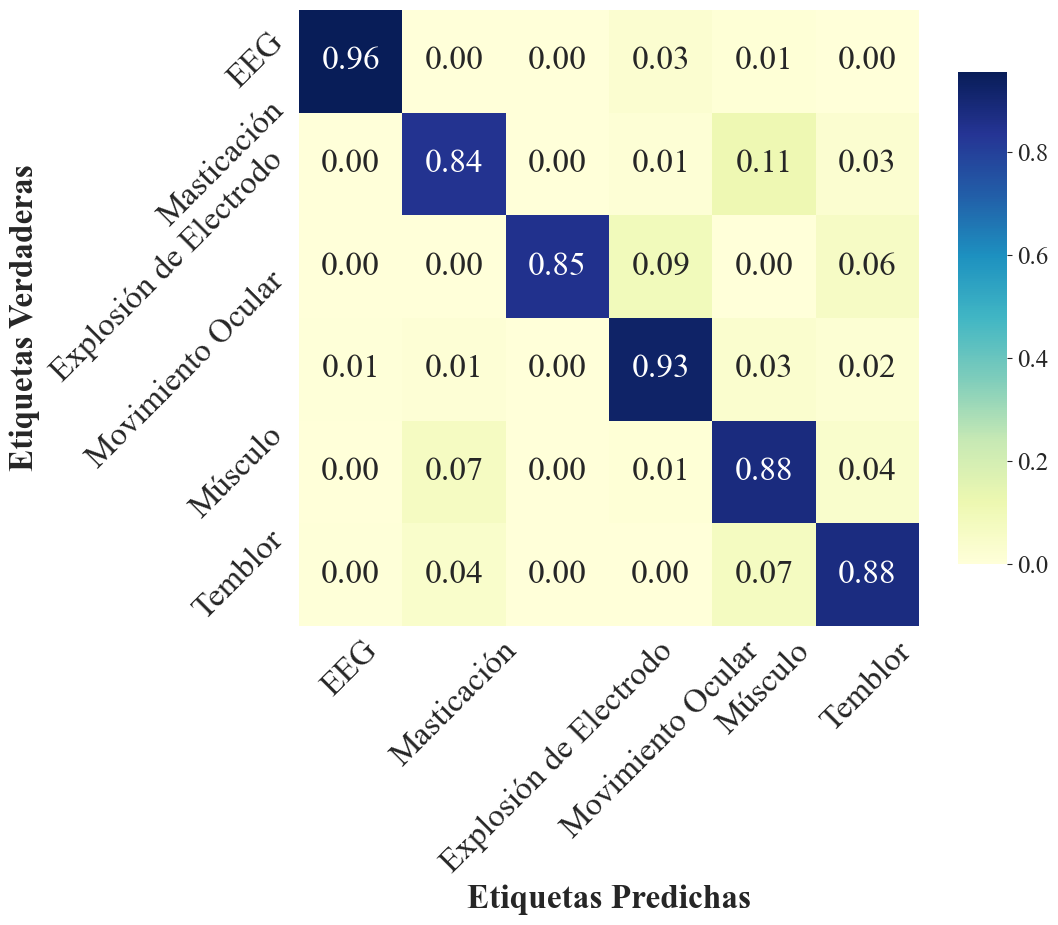

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.51it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8991
  Exactitud Promedio por Clase (macro): 0.9664
  Precisión General (macro): 0.9115
  Sensibilidad General (macro): 0.8886
  F1 General (macro): 0.8985

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9882
  - Precisión   : 0.9896
  - Sensibilidad: 0.9566
  - F1          : 0.9728
  - Especificidad: 0.9972
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9436
  - Precisión   : 0.8878
  - Sensibilidad: 0.8440
  - F1          : 0.8654
  - Especificidad: 0.9709
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9988
  - Precisión   : 1.0000
  - Sensibilidad: 0.8485
  - F1          : 0.9180
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9707
  - Precisión   : 0.9449
  - Sensibilidad: 0.9255
  - F1          : 0.9351
  - Especificidad: 0.9841
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9316
  - Precisión   : 0.8116
  - Sensibilidad: 0.8814


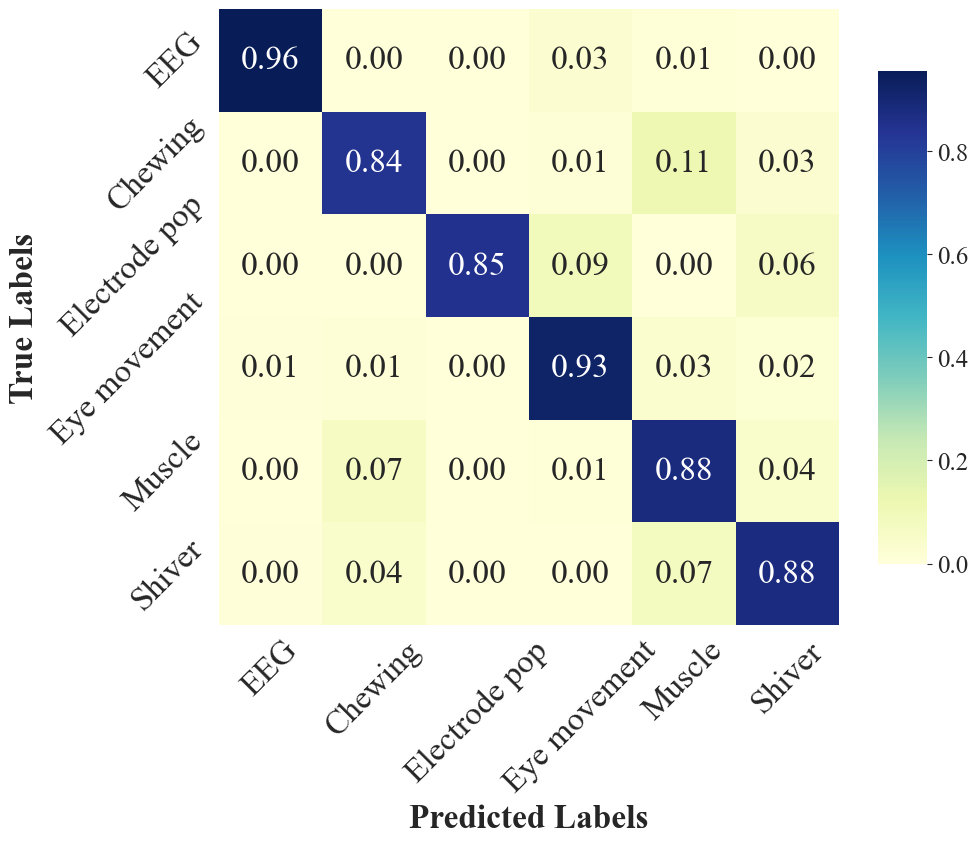

(0.8990893428501108,
 np.float64(0.9663631142833703),
 0.9114824034789969,
 0.8885834062925361,
 0.8985221717404492,
 [np.float64(0.9881860694068423),
  np.float64(0.9436377061284765),
  np.float64(0.9987693822298794),
  np.float64(0.9707112970711297),
  np.float64(0.9315776519812946),
  np.float64(0.965296578882599)],
 array([0.98963134, 0.88781665, 1.        , 0.94487321, 0.81156317,
        0.83501006]),
 array([0.95657016, 0.8440367 , 0.84848485, 0.92548596, 0.88139535,
        0.87552743]),
 array([0.97281993, 0.86537331, 0.91803279, 0.93507911, 0.84503902,
        0.85478888]),
 [np.float64(0.9971563981042654),
  np.float64(0.9708555311814479),
  np.float64(1.0),
  np.float64(0.9840612049729041),
  np.float64(0.9450515142054324),
  np.float64(0.9771524101421009)],
 array([[0.95657016, 0.        , 0.        , 0.02895323, 0.01113586,
         0.00334076],
        [0.00114679, 0.8440367 , 0.        , 0.01376147, 0.11353211,
         0.02752294],
        [0.        , 0.        , 0.84

In [90]:
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='en')
#evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='es')
#evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='en')

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.69it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.9328
  Exactitud Promedio por Clase (macro): 0.9776
  Precisión General (macro): 0.9044
  Sensibilidad General (macro): 0.9053
  F1 General (macro): 0.9044

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9840
  - Precisión   : 0.9325
  - Sensibilidad: 1.0000
  - F1          : 0.9651
  - Especificidad: 0.9795
  - Soporte     : 898
Clase Masticación:
  - Exactitud   : 0.9584
  - Precisión   : 0.8999
  - Sensibilidad: 0.9071
  - F1          : 0.9035
  - Especificidad: 0.9724
  - Soporte     : 872
Clase Explosión de Electrodo:
  - Exactitud   : 0.9966
  - Precisión   : 0.7879
  - Sensibilidad: 0.7879
  - F1          : 0.7879
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Movimiento Ocular:
  - Exactitud   : 0.9764
  - Precisión   : 0.9727
  - Sensibilidad: 0.9222
  - F1          : 0.9468
  - Especificidad: 0.9923
  - Soporte     : 926
Clase Músculo:
  - Exactitud   : 0.9815
  - Precisión   : 0.9769
  - 

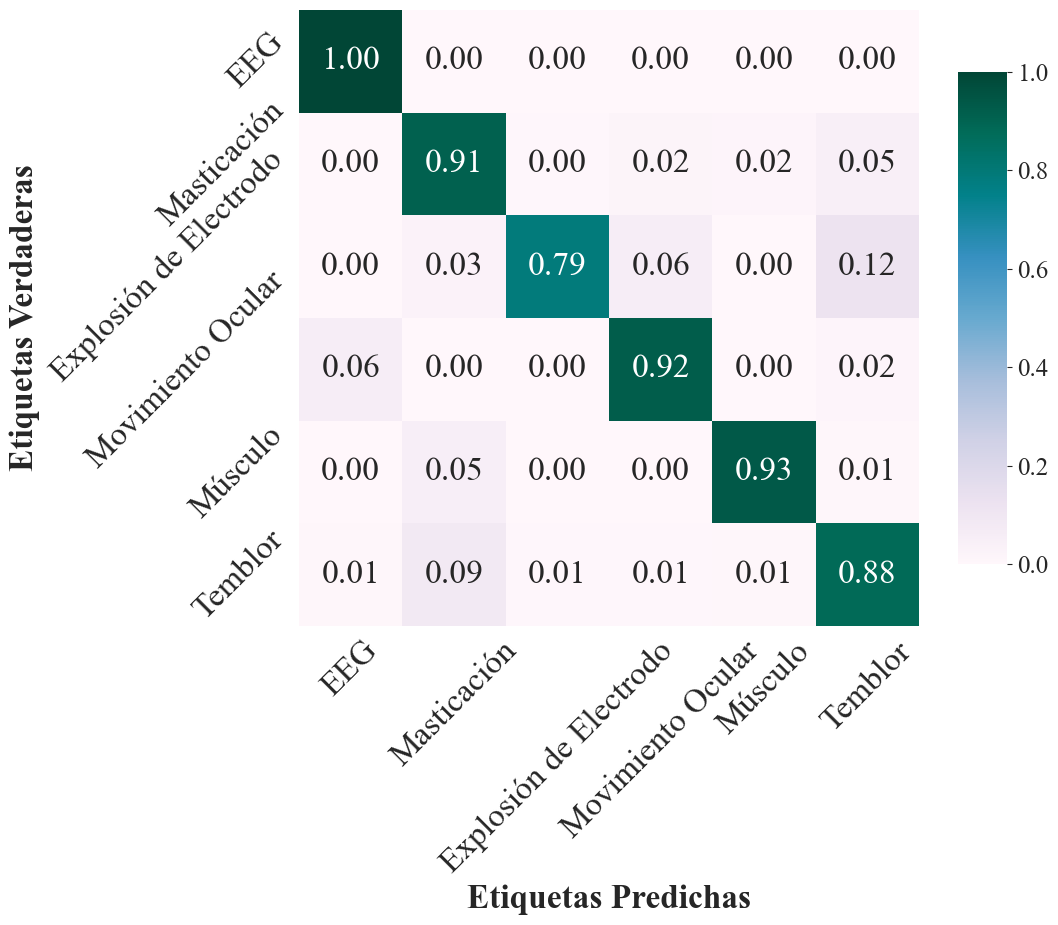

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.95it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.9328
  Exactitud Promedio por Clase (macro): 0.9776
  Precisión General (macro): 0.9044
  Sensibilidad General (macro): 0.9053
  F1 General (macro): 0.9044

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9840
  - Precisión   : 0.9325
  - Sensibilidad: 1.0000
  - F1          : 0.9651
  - Especificidad: 0.9795
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9584
  - Precisión   : 0.8999
  - Sensibilidad: 0.9071
  - F1          : 0.9035
  - Especificidad: 0.9724
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9966
  - Precisión   : 0.7879
  - Sensibilidad: 0.7879
  - F1          : 0.7879
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9764
  - Precisión   : 0.9727
  - Sensibilidad: 0.9222
  - F1          : 0.9468
  - Especificidad: 0.9923
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9815
  - Precisión   : 0.9769
  - Sensibilidad: 0.934

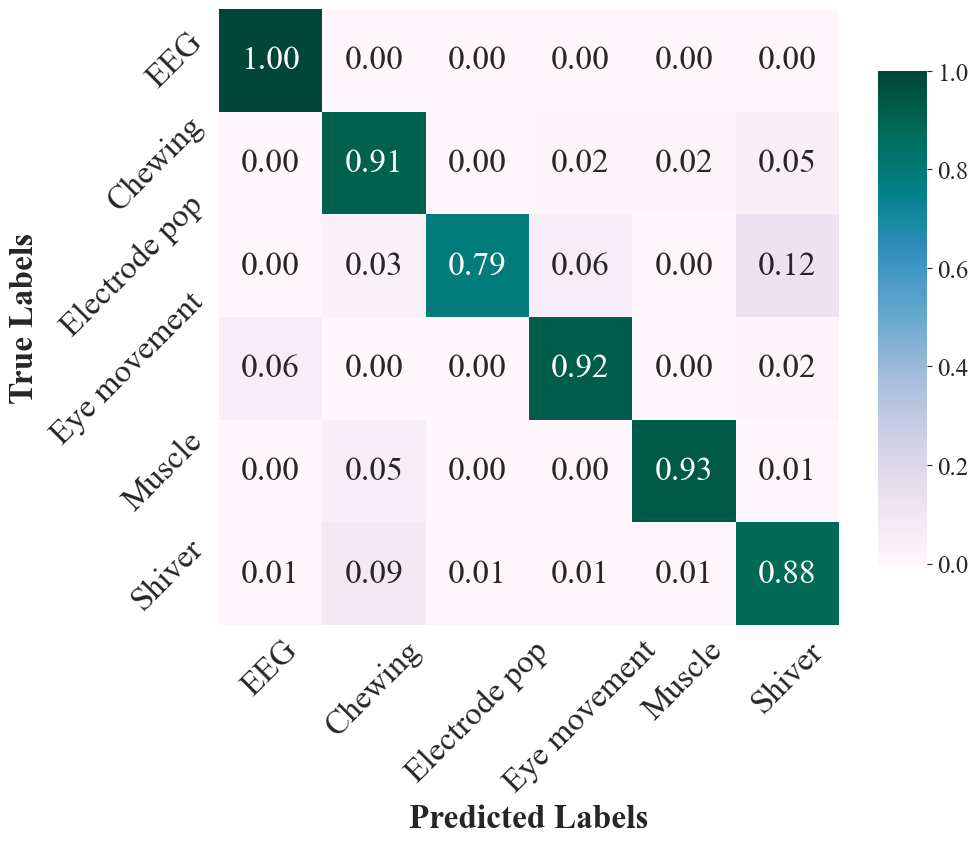

(0.9328082697514152,
 np.float64(0.977602756583805),
 0.90435155504742,
 0.9053109427162589,
 0.904417114900562,
 [np.float64(0.9840019689884322),
  np.float64(0.9584051193699237),
  np.float64(0.9965542702436623),
  np.float64(0.9763721388136845),
  np.float64(0.981540733448191),
  np.float64(0.9687423086389367)],
 array([0.9325026 , 0.89988623, 0.78787879, 0.97266515, 0.97691373,
        0.85626283]),
 array([1.        , 0.90711009, 0.78787879, 0.92224622, 0.93488372,
        0.87974684]),
 array([0.96507254, 0.90348372, 0.78787879, 0.94678492, 0.95543672,
        0.86784599]),
 [np.float64(0.9794628751974723),
  np.float64(0.9724224381071764),
  np.float64(0.9982630272952854),
  np.float64(0.992349378386994),
  np.float64(0.9940680611926319),
  np.float64(0.9804959598774031)],
 array([[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.00344037, 0.90711009, 0.00458716, 0.0206422 , 0.01720183,
         0.04701835],
        [0.        , 0.0303

In [91]:
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='en')
#evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='es')
#evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='en')

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.07it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8991
  Exactitud Promedio por Clase (macro): 0.9664
  Precisión General (macro): 0.9115
  Sensibilidad General (macro): 0.8886
  F1 General (macro): 0.8985

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9882
  - Precisión   : 0.9896
  - Sensibilidad: 0.9566
  - F1          : 0.9728
  - Especificidad: 0.9972
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9436
  - Precisión   : 0.8878
  - Sensibilidad: 0.8440
  - F1          : 0.8654
  - Especificidad: 0.9709
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9988
  - Precisión   : 1.0000
  - Sensibilidad: 0.8485
  - F1          : 0.9180
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9707
  - Precisión   : 0.9449
  - Sensibilidad: 0.9255
  - F1          : 0.9351
  - Especificidad: 0.9841
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9316
  - Precisión   : 0.8116
  - Sensibilidad: 0.8814


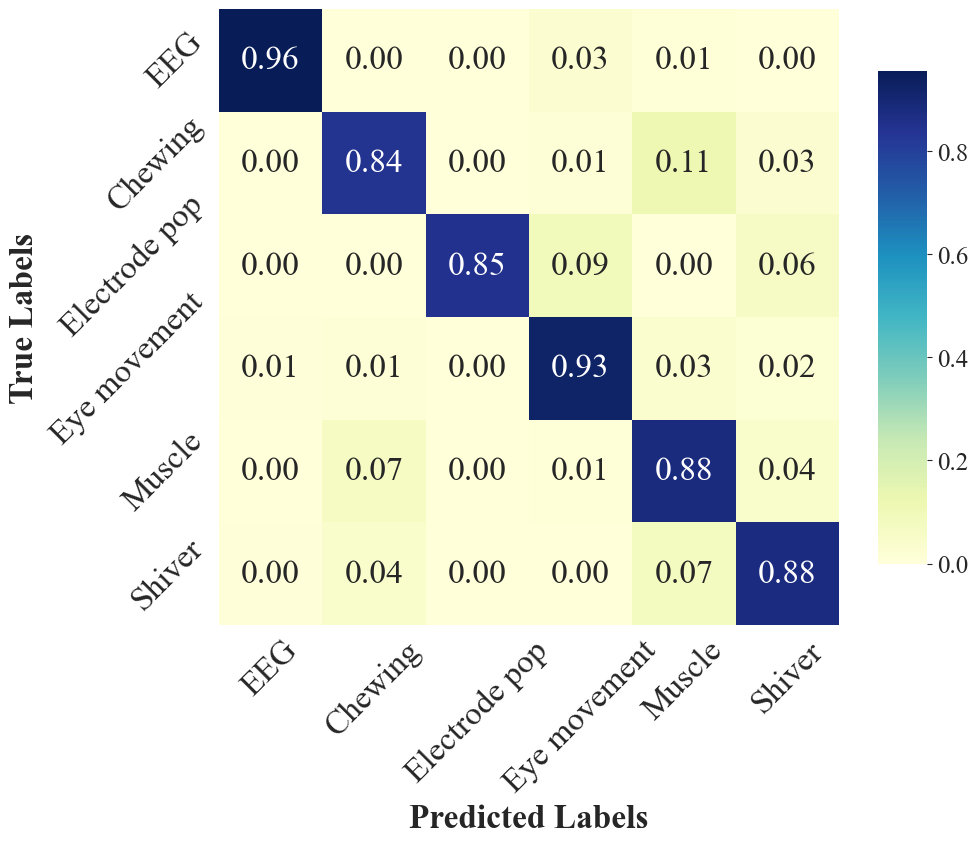

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.67it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.9328
  Exactitud Promedio por Clase (macro): 0.9776
  Precisión General (macro): 0.9044
  Sensibilidad General (macro): 0.9053
  F1 General (macro): 0.9044

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9840
  - Precisión   : 0.9325
  - Sensibilidad: 1.0000
  - F1          : 0.9651
  - Especificidad: 0.9795
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9584
  - Precisión   : 0.8999
  - Sensibilidad: 0.9071
  - F1          : 0.9035
  - Especificidad: 0.9724
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9966
  - Precisión   : 0.7879
  - Sensibilidad: 0.7879
  - F1          : 0.7879
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9764
  - Precisión   : 0.9727
  - Sensibilidad: 0.9222
  - F1          : 0.9468
  - Especificidad: 0.9923
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9815
  - Precisión   : 0.9769
  - Sensibilidad: 0.934

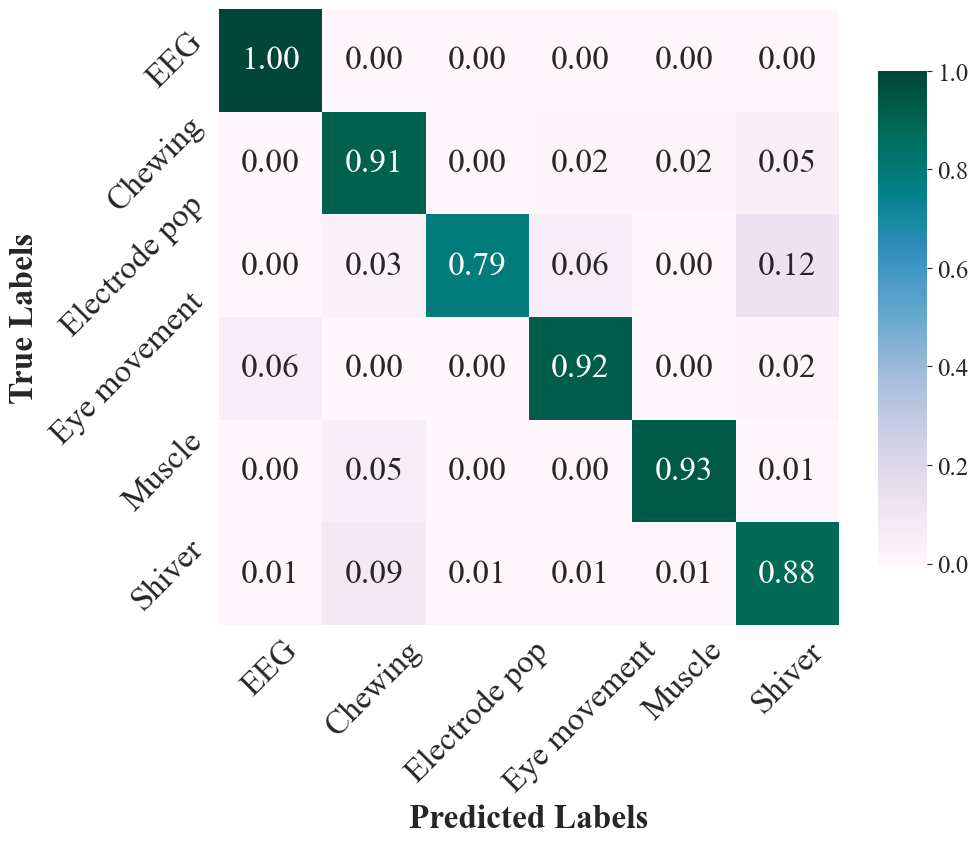


=== Resumen general ===
Source: Acc(micro)=0.8991 | Acc(macro)=0.9664 | P=0.9115 | R=0.8886 | F1=0.8985
Target: Acc(micro)=0.9328 | Acc(macro)=0.9776 | P=0.9044 | R=0.9053 | F1=0.9044
AVG : Acc(micro)=0.9159 | Acc(macro)=0.9720 | P=0.9079 | R=0.8969 | F1=0.9015


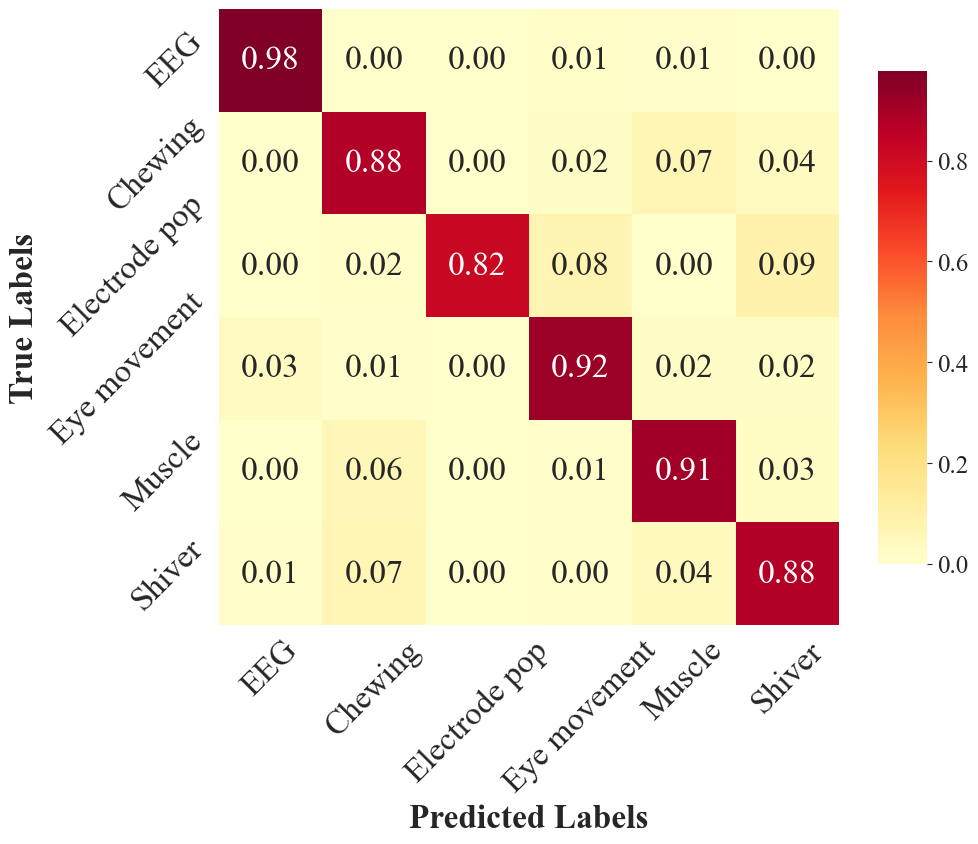

In [103]:
import numpy as np

def evaluate_both_domains_with_confusion(
    model_source, model_target, dataloader, class_names, device, language='es'
):
    (src_acc, src_macro_acc, src_prec, src_rec, src_f1,
     src_cls_acc, src_cls_prec, src_cls_rec, src_cls_f1,
     src_cls_spec, src_cm) = evaluate_domain(
        model_source, dataloader, class_names, device,
        domain='source', language=language
    )

    (tgt_acc, tgt_macro_acc, tgt_prec, tgt_rec, tgt_f1,
     tgt_cls_acc, tgt_cls_prec, tgt_cls_rec, tgt_cls_f1,
     tgt_cls_spec, tgt_cm) = evaluate_domain(
        model_target, dataloader, class_names, device,
        domain='target', language=language
    )

    avg_metrics = {
        'accuracy_micro': (src_acc + tgt_acc) / 2.0,
        'accuracy_macro': (src_macro_acc + tgt_macro_acc) / 2.0,
        'precision_macro': (src_prec + tgt_prec) / 2.0,
        'recall_macro': (src_rec + tgt_rec) / 2.0,
        'f1_macro': (src_f1 + tgt_f1) / 2.0
    }

    avg_conf_matrix = (src_cm + tgt_cm) / 2.0

    # Promedios por clase
    avg_per_class = {
        'accuracy': (np.array(src_cls_acc) + np.array(tgt_cls_acc)) / 2.0,
        'precision': (np.array(src_cls_prec) + np.array(tgt_cls_prec)) / 2.0,
        'recall': (np.array(src_cls_rec) + np.array(tgt_cls_rec)) / 2.0,
        'f1': (np.array(src_cls_f1) + np.array(tgt_cls_f1)) / 2.0,
        'specificity': (np.array(src_cls_spec) + np.array(tgt_cls_spec)) / 2.0
    }

    dom_lbl = {'es': ('Fuente', 'Objetivo'), 'en': ('Source', 'Target')}
    s_lbl, t_lbl = dom_lbl.get(language, ('Source', 'Target'))
    print("\n=== Resumen general ===")
    print(f"{s_lbl}: Acc(micro)={src_acc:.4f} | Acc(macro)={src_macro_acc:.4f} | "
          f"P={src_prec:.4f} | R={src_rec:.4f} | F1={src_f1:.4f}")
    print(f"{t_lbl}: Acc(micro)={tgt_acc:.4f} | Acc(macro)={tgt_macro_acc:.4f} | "
          f"P={tgt_prec:.4f} | R={tgt_rec:.4f} | F1={tgt_f1:.4f}")
    print(f"AVG : Acc(micro)={avg_metrics['accuracy_micro']:.4f} | "
          f"Acc(macro)={avg_metrics['accuracy_macro']:.4f} | "
          f"P={avg_metrics['precision_macro']:.4f} | "
          f"R={avg_metrics['recall_macro']:.4f} | "
          f"F1={avg_metrics['f1_macro']:.4f}")

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(
        avg_conf_matrix,
        annot=True, fmt=".2f", cmap="YlOrRd",
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size":24},
        cbar_kws={"shrink":0.8,"aspect":10}
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)

    title = (
        "Matriz de Confusión Promedio (Fuente + Objetivo)"
        if language=='es' else
        "Confusion Matrix (Source - Target)"
    )
    xlabel = "Etiquetas Predichas" if language=='es' else "Predicted Labels"
    ylabel = "Etiquetas Verdaderas" if language=='es' else "True Labels"

    plt.xlabel(xlabel, fontsize=24, fontweight='bold')
    plt.ylabel(ylabel, fontsize=24, fontweight='bold')
    #plt.title(title, fontsize=26, fontweight='bold')
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(rotation=45, fontsize=24)
    plt.show()

    return {
        'source_metrics': (src_acc, src_macro_acc, src_prec, src_rec, src_f1),
        'target_metrics': (tgt_acc, tgt_macro_acc, tgt_prec, tgt_rec, tgt_f1),
        'avg_metrics': avg_metrics,
        'avg_conf_matrix': avg_conf_matrix,
        'per_class_avg': avg_per_class
    }


resultados = evaluate_both_domains_with_confusion(
    model_source,
    model_target,
    test_loader,
    class_names,
    device,
    language='en'
)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

def plot_training_metrics(csv_path, language='en', save_path=None, y_min=0.0, y_max=1.0):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Source Acc'], label='Exactitud de Entrenamiento (Fuente)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Exactitud de Entrenamiento (Objetivo)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Exactitud de Validación (Fuente)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Exactitud de Validación (Objetivo)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Entrenamiento y Validación de Exactitud\n', fontsize=24, fontweight='bold')
        plt.xlabel('Épocas', fontsize=24, fontweight='bold')
        plt.ylabel('Exactitud', fontsize=24, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Source Acc'], label='Training Accuracy (Source)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Training Accuracy (Target)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Validation Accuracy (Source)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Validation Accuracy (Target)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        #plt.title('Training and Validation Accuracy\n', fontsize=24, fontweight='bold')
        plt.xlabel('Epochs', fontsize=24, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=24, fontweight='bold')
    
    plt.ylim(0.5, 1)
    plt.xticks(ticks=range(0, len(df.index) + 10, 10), fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(
        loc='lower right',
        fontsize=20,
        labelspacing=0.5,   # Espaciado vertical entre líneas
        borderpad=0.5,      # Espacio interno entre la caja y el texto
        frameon=True,
        fancybox=True
    )
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


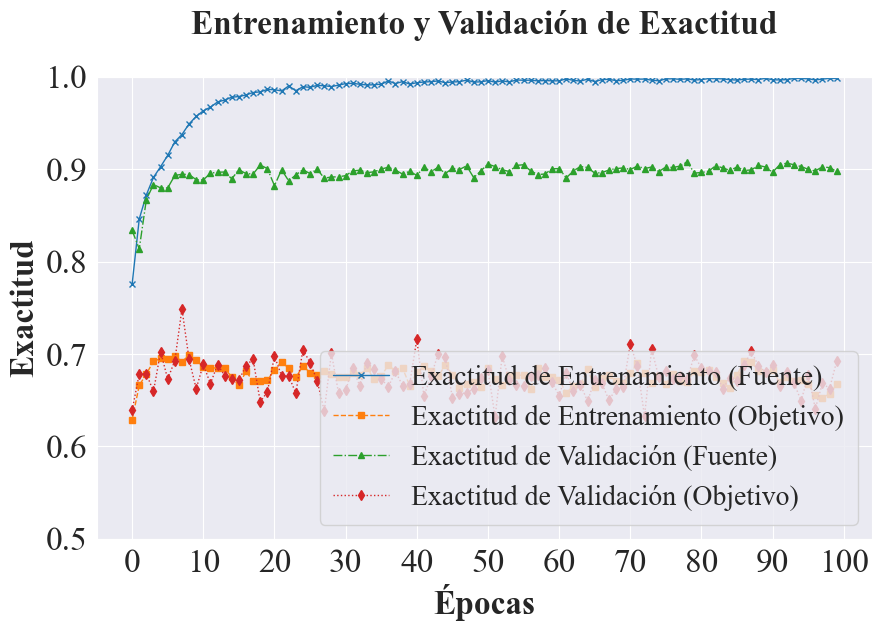

In [3]:
plot_training_metrics('training_metrics_stft.csv', language='es')

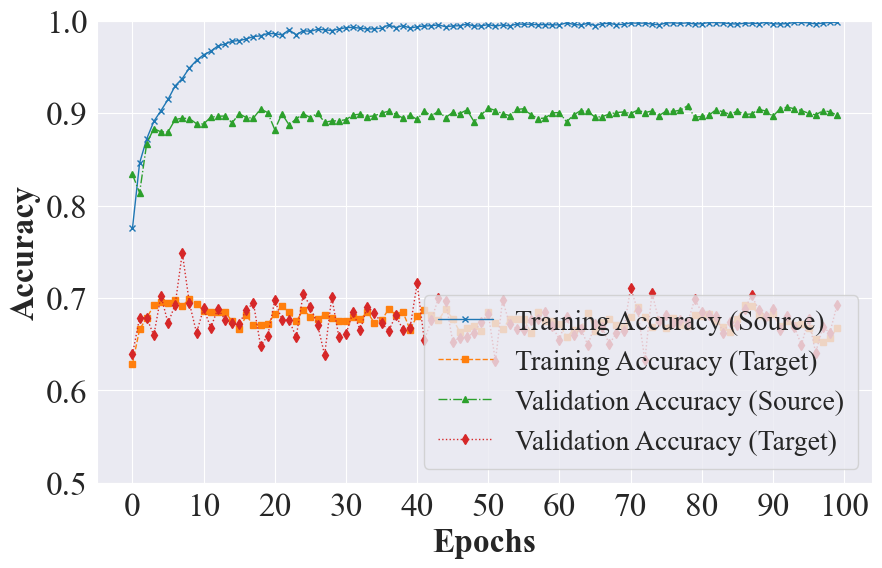

In [4]:
plot_training_metrics('training_metrics_stft.csv', language='en')

In [5]:
def plot_domain_adaptation_loss(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Loss'], label='Pérdida de Adaptación de Dominio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Pérdida de Adaptación de Dominio\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Pérdida', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Loss'], label='Domain Adaptation Loss', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        #plt.title('Domain Adaptation Loss\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Loss', fontsize=18, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=18)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

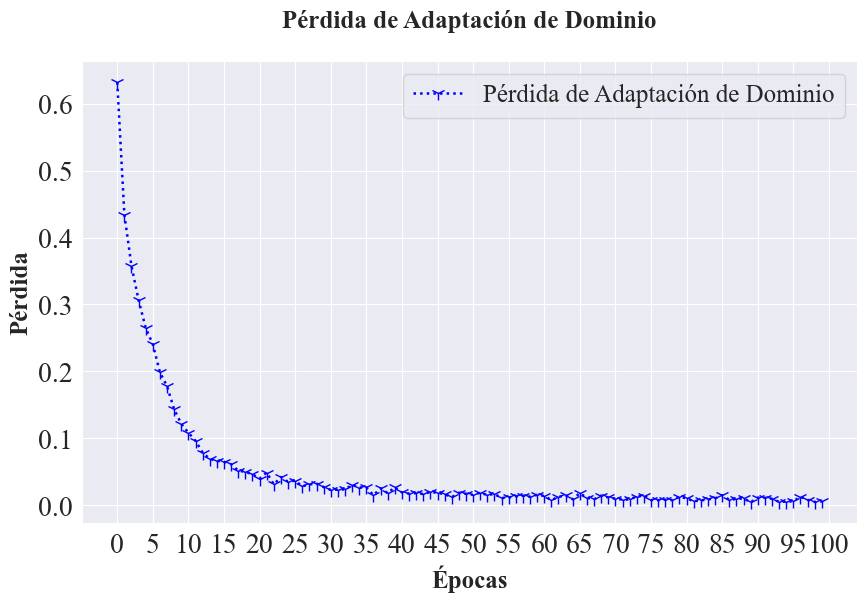

In [6]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='es')

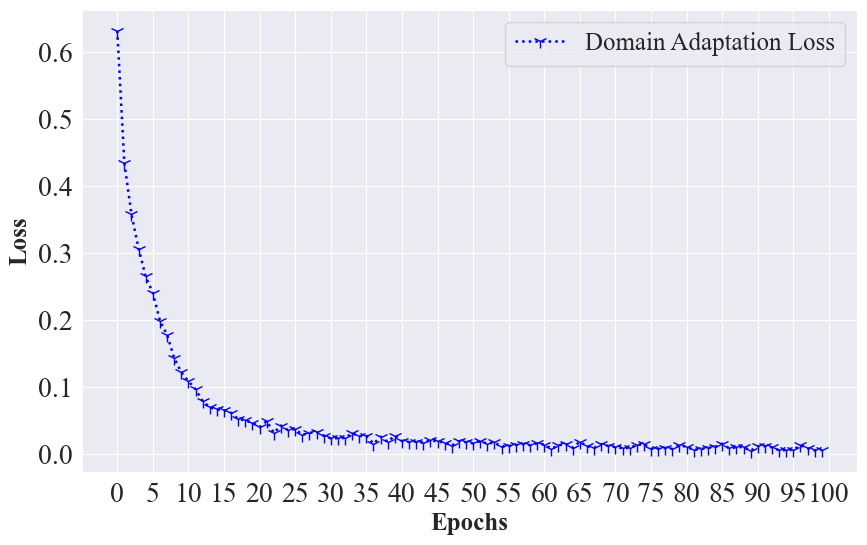

In [7]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='en')

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_divergence_metrics(csv_path, language='en', save_path=None):
    sns.set_style("white")
    plt.rc('font', family='Times New Roman')

    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))

    # Plot
    if language == 'es':
        plt.plot(df.index, df['Avg KL Divergence'], label='Divergencia KL Promedio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Divergencia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Distancia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)

        plt.title('Métricas de Divergencia y Distancia\n', fontsize=24, fontweight='bold')
        plt.xlabel('Épocas', fontsize=24, fontweight='bold')
        plt.ylabel('Valores', fontsize=24, fontweight='bold')
    else:
        plt.plot(df.index, df['Avg KL Divergence'], label='Avg KL Divergence', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Avg Jensen-Shannon Divergence', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Avg Jensen-Shannon Distance', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)

        plt.xlabel('Epochs', fontsize=35, fontweight='bold')
        plt.ylabel('Values', fontsize=35, fontweight='bold')

    # X ticks
    plt.xticks(ticks=range(0, len(df.index) + 10, 10), fontsize=35)

    # Y ticks
    y_min = df[['Avg KL Divergence','Avg Jensen-Shannon Divergence','Avg Jensen-Shannon Distance']].min().min()
    y_max = df[['Avg KL Divergence','Avg Jensen-Shannon Divergence','Avg Jensen-Shannon Distance']].max().max()
    plt.yticks(ticks=range(int(y_min), int(y_max) + 1, 1), fontsize=35)

    # Background white
    plt.gca().set_facecolor("white")
    plt.gcf().set_facecolor("white")

    plt.grid(True, linestyle=':', linewidth=1)
    plt.legend(loc='upper right', fontsize=25)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()


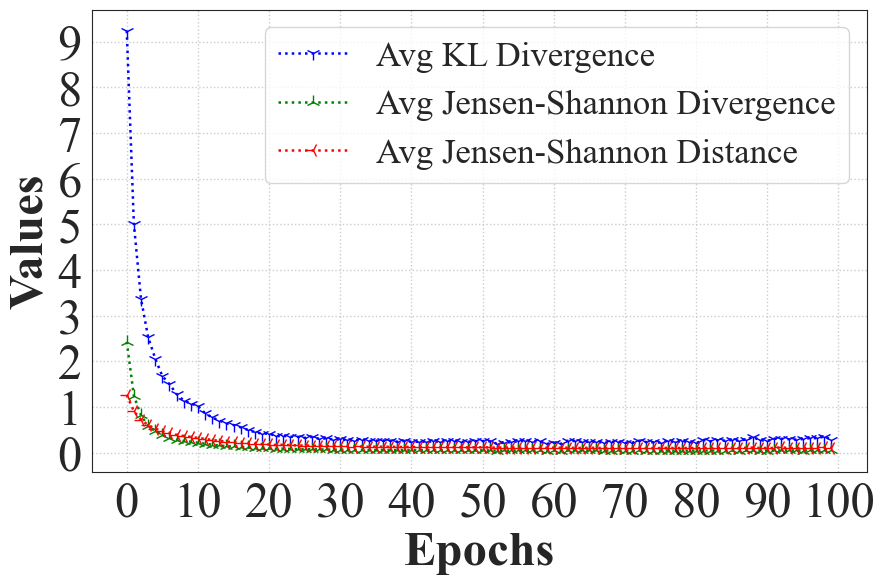

In [14]:
plot_divergence_metrics('_divergence_metrics_stft.csv', language='en')

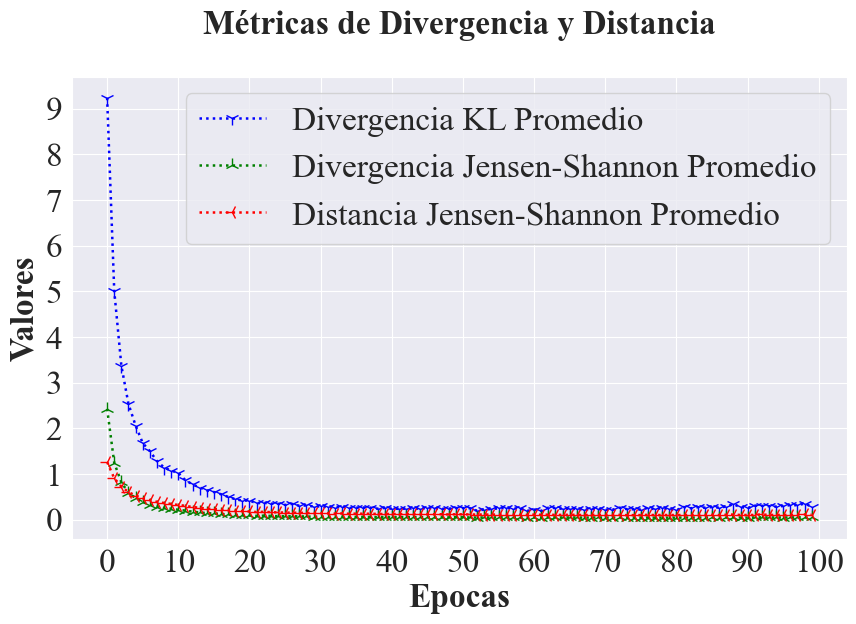

In [12]:
plot_divergence_metrics('_divergence_metrics_stft.csv', language='es')